# Few-Shot Learning

**Challenge:** [Omniglot](https://github.com/brendenlake/omniglot), the "transpose" of MNIST, with 1,623 character classes, each with 20 examples. Build a few-shot classifier with a target of <35% error.

## Exploring the Dataset

**[Omniglot](https://github.com/brendenlake/omniglot)** is a collection of 1,623 hand drawn characters from 50 alphabets. Each of the 1,623 characters is drawn online via *Amazon's Mechanical Turk* by 20 different people at resolution of `105x105`. It is sometimes reffered to as the **"Trasnpose of MNIST"**, since it has 1,623 types of character with only 20 examples each, in contrast to MNIST having thousands of examples for only 10 digits.

Data Structure:
```sh
$ tree all_runs/ -L 2
 all_runs
├── run01
│   ├── class_labels.txt
│   ├── test
│   └── training
├── run02
│   ├── class_labels.txt
│   ├── test
│   └── training
├── run03
│   ├── class_labels.txt
│   ├── test
│   └── training
│
├── ...
│
├── run18
│   ├── class_labels.txt
│   ├── test
│   └── training
├── run19
│   ├── class_labels.txt
│   ├── test
│   └── training
└── run20
    ├── class_labels.txt
    ├── test
    └── training

60 directories, 20 files
```

Omniglot contains 20 examples called "runs" each run has `class_labels.txt`, `test` and `training` folders. Let's see what's going on visually:

```sh
$ tree all_runs/run0
all_runs/run01
├── class_labels.txt
├── test
│   ├── item01.png
│   ├── item02.png
│   ├── item03.png
│   ├── item04.png
│   ├── ...
│   ├── item17.png
│   ├── item18.png
│   ├── item19.png
│   └── item20.png
└── training
    ├── class01.png
    ├── class02.png
    ├── class03.png
    ├── ...
    ├── class17.png
    ├── class18.png
    ├── class19.png
    └── class20.png

2 directories, 41 files
```

### N-way One-shot learning

Given a tiny labelled training set $S$, which has $ N $ examples, each vectors of the same dimension with a distinct label $y$.

$$ S = \{(x_i, y_i), ..., (x_N, y_N)\} $$

We're also given $\hat{x}$, the test example it has to classify. Since exactly one example in the training set has the right class, the aim is to correctly predict which $y \in S$ is the same as $\hat{x}$'s label, $\hat{y}$.

- Real world problems might not always have the constraint that exactly one image has the correct class.

- It's easy to generalize to k-shot learning by having there be $k$ examples for each $y_i$ rather than just one.

- When $N$ is higher, there are more possible classes that $\hat{x}$ can belong to, so it's harder to predict the correct one.

- Randomly guessing will average ${100\over n}\%$ accuracy.


Let's visualze some examples in the Omniglot dataset.

In [3]:
%matplotlib inline

# For OS operations.
import os

# Dataset helper.
import omniglot

# Model helper.
import model

Sucessfully extracted to datasets/extracted/all_runs
Sucessfully extracted to datasets/extracted/images_background


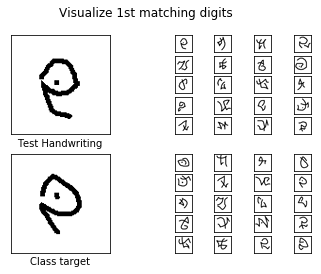

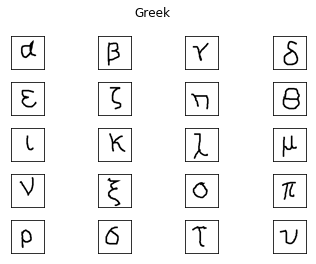

In [5]:
# # Data directory.
# data_dir = omniglot.data_dir

# # Directory containing compressed files.
# comp_dir = omniglot.compressed_dir

# # Extract `all_runs`.
# all_runs_dir = omniglot.Data.extract(os.path.join(comp_dir, 'all_runs.tar.gz'))
# image_bg_dir = omniglot.Data.extract(os.path.join(comp_dir, 'images_background.tar.gz'))

# # Visualize 1st run.
# # Emphasis 1st matching digits in "class_labels.txt".
# omniglot.Visualize.runs(directory=os.path.join(all_runs_dir, 'run01'),
#                         index=0,  # Index to emphasize on.
#                         title='Visualize 1st matching digits')

# # Visualize one random character from 20 different classes of Greek alphabet.
# omniglot.Visualize.symbols(directory=os.path.join(image_bg_dir, 'Greek'))

train_dir = os.path.join(omniglot.data_dir, 'images_background')
eval_dir = os.path.join(omniglot.data_dir, 'images_evalutaion')

data = omniglot.Dataset(data_dir=train_dir)

network = model.SiameseNetwork()

network.compile(optimizer='adam',
                loss=network.contractive_loss)


## Exploring Models

### One-Shot Learning Baseline over Nearest Neighbor

The simplest way to perform classification is with **K-Nearest Neighbors**, but since there are only one example per class, we're only allowed 1 nearest neighbor lookup –which is really bad! K-Nearest Neigbors usually performs well with 5 neighbors or more *(but this also depends on dataset & it's sparsity)*.

Nearest Neighbor: This is just a way of measuring distance in a higher dimensional plane using distance metrics such as [Euclidean Distance]().

$$ \textrm{Euclidean Distance} = \sqrt{\sum_i^n{(q_i - p_i)^2}}$$

After calculating the Euclidean disance over `k` nearest neighbors. We then take the closest one:

$$ C(\hat{x}) = \underset{c \in S}{\operatorname{argmax}} \big\|\hat{x} - x_c\big\| $$

After calculating the Euclidean disance over `k` nearest neighbors. We then take the closest one:
